Here I will illustrate the steps needed to fit the behavioural model to empirical data. This entails determining posterior beleifs over model parameters and mini-block specific planning depth.

In [2]:
import torch

from scipy import io

import pandas as pd

from torch import zeros, ones

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context = 'talk', style = 'white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

# function for plotting asymetric errorbars
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1].values
    
    unique_subjects = np.unique(subjects)
    nsub = len(unique_subjects)
    
    values = values.reshape(-1, nsub)
    
    quantiles = np.percentile(values, [5, 50, 95], axis=0)
    
    low_perc = quantiles[0]
    up_perc = quantiles[-1]
    
    x = unique_subjects
    y = quantiles[1]

    assert np.all(low_perc <= y)
    assert np.all(y <= up_perc)
    
    kwargs['yerr'] = [y-low_perc, up_perc-y]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x, y, **kwargs)
    
# function for mapping strings ('high', 'low') to numbers 0, 1

def map_noise_to_values(strings):
    for s in strings:
        if s[0] == 'high':
            yield 1
        elif s[0] == 'low':
            yield 0
        else:
            yield np.nan

In [13]:
# load and format behavioural data
        
from pathlib import Path
home = str(Path.home())    

from os import listdir
path = home + '/tudcloud/Shared/Experiments/Plandepth/B03_pilot_OA/main/'
fnames = listdir(path)

runs = len(fnames)  # number of subjects
mini_blocks = 100  # number of mini blocks in each run
max_trials = 3  # maximal number of trials within a mini block
max_depth = 3  # maximal planning depth

na = 2  # number of actions
ns = 6 # number of states/locations
no = 5 # number of outcomes/rewards

responses = zeros(runs, mini_blocks, max_trials)
states = zeros(runs, mini_blocks, max_trials+1, dtype=torch.long)
scores = zeros(runs, mini_blocks, max_depth)
conditions = zeros(2, runs, mini_blocks, dtype=torch.long)
confs = zeros(runs, mini_blocks, 6, dtype=torch.long)
for i,f in enumerate(fnames):
    parts = f.split('_')
    tmp = io.loadmat(path+f)
    responses[i] = torch.from_numpy(tmp['data']['Responses'][0,0]['Keys'][0,0]-1)
    states[i] = torch.from_numpy(tmp['data']['States'][0,0] - 1).long()
    confs[i] = torch.from_numpy(tmp['data']['PlanetConf'][0,0] - 1).long()
    scores[i] = torch.from_numpy(tmp['data']['Points'][0,0])
    strings = tmp['data']['Conditions'][0,0]['noise'][0,0][0]
    conditions[0, i] = torch.tensor(list(map_noise_to_values(strings)), dtype=torch.long)
    conditions[1, i] = torch.from_numpy(tmp['data']['Conditions'][0,0]['notrials'][0,0][:,0]).long()
    
states[states < 0] = -1
confs = torch.eye(no)[confs]

# define dictionary containing information which participants recieved on each trial
stimuli = {'conditions': conditions,
           'states': states, 
           'configs': confs}

mask = ~torch.isnan(responses)

In [14]:
# Probabilistic inference
import sys
sys.path.append('../')

from agents import BackInduction
from inference import Inferrer

# define agent
agent = BackInduction(confs,
                      runs=runs,
                      mini_blocks=mini_blocks,
                      trials=max_trials,
                      planning_depth=max_depth)

# load inference module and start model fitting
infer = Inferrer(agent, stimuli, responses, mask)
infer.fit(num_iterations=400, parametrisation='dynamic')  # alternative parametrisation='static'

Mean ELBO 1384.74: 100%|██████████| 400/400 [2:22:23<00:00, 21.36s/it]  


RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

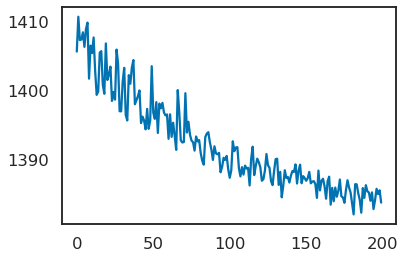

In [15]:
# plot results

plt.figure()
plt.plot(infer.loss[-200:])

labels = [r'$\beta$', r'$\theta$', r'$\epsilon$']
pars_df, scales_df, mg_df, sg_df = infer.sample_from_posterior(labels)

pars_df[r'$\beta$'] = np.exp(pars_df[r'$\beta$'].values)
pars_df[r'$\epsilon$'] = sigmoid(pars_df[r'$\epsilon$'].values)

pars_df = pars_df.melt(id_vars='subject', var_name='parameter')

g = sns.FacetGrid(pars_df, col="parameter", height=3, sharey=False);
g = (g.map(errorplot, 'subject', 'value'));

g = sns.PairGrid(mg_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

g = sns.PairGrid(sg_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)


ng = len(f1)  # number of participants in the first group

n_samples = 100
post_depth = infer.sample_posterior_marginal(n_samples=n_samples)

probs = np.zeros((mini_blocks, max_trials-1, n_samples, runs, 3))
for b in range(mini_blocks):
    for t in range(max_trials-1):
        tmp = post_depth['d_{}_{}'.format(b, t)]
        probs[b, t, :, :ng] = tmp[:, :ng]
        if b < 50:
            probs[b+50 , t, :, ng:] = tmp[:, ng:]
        else:
            probs[b-50, t, :, ng:] = tmp[:, ng:]

count = np.array([np.sum(probs.argmax(-1) == i, axis=-2) for i in range(3)])
trial_count = count.sum(-1)
trial_count = trial_count/trial_count.sum(0)            
for i in range(max_trials-1):
    plt.figure(figsize=(10, 5))
    sns.heatmap(trial_count[..., i], cmap='viridis')
    
cond_count = count.reshape(3, 4, 25, 2, runs).sum(-3)
cond_probs = cond_count/cond_count.sum(0)

plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(data=cond_probs[[1, 1, 2, 2], [0, 1, 2, 3], 0].T, 
                              columns=['1', '2', '3', '4']), 
                              color='b')
plt.ylim([0, 1.01])
plt.xlabel('phase')
plt.ylabel('exceedance probability')